In [12]:
# import all packages
import pandas as pd 
import numpy as np 
import textwrap 

import seaborn as sns 
import matplotlib.pyplot as plt 

import shap 

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RepeatedKFold, cross_val_score, GridSearchCV 
from sklearn.metrics import r2_score, mean_absolute_error 

import statsmodels.api as sm

In [13]:
url = "https://raw.githubusercontent.com/geo-smart/XAI_coastalLA/main/minimal_preprocessing_dataset.csv" # Make sure the url is the raw version of the file on GitHub
df = pd.read_csv(url)
print("Number of Columns: ", len(df.columns))
df.head()

Number of Columns:  107


,Unnamed: 0,Accretion Measurement 1 (mm),Accretion Measurement 2 (mm),Accretion Measurement 3 (mm),Accretion Measurement 4 (mm),Latitude,Longitude,Year (yyyy),Month (mm),Average Accretion (mm),...,percent_waterlevel_complete,Unnamed: 6,Surface Elevation Change Rate (cm/y),Flood Freq (Floods/yr),Avg. Flood Depth when Flooded (ft),90th Percentile Flood Depth when Flooded (ft),10th Percentile Flood Depth when Flooded (ft),Std. Deviation Flood Depth when Flooded,Acc_rate_fullterm (cm/y),Average_Marsh_Elevation (ft. NAVD88)
0,CRMS0002,32.545,34.0,34.0,30.0,30.100356,-89.791784,2016.0,4.0,28.75,...,97.739726,NaN,0.49,163.104824,0.442805,1.104,0.00,0.506806,1.05,0.351500
1,CRMS0003,24.500,23.0,24.0,11.0,30.099396,-89.252697,2015.0,4.0,11.25,...,99.965753,NaN,0.55,243.955101,0.140492,0.531,0.00,0.333084,1.26,0.853500
2,CRMS0006,28.000,30.0,27.0,20.5,30.263548,-89.982233,2016.0,4.0,18.50,...,98.390411,NaN,0.41,57.171053,0.334836,0.898,0.00,0.445684,1.18,0.522500
3,CRMS0008,0.000,0.0,0.0,0.0,30.228348,-90.685225,2016.0,5.0,0.00,...,0.000000,NaN,0.42,69.701166,0.729878,1.270,0.27,0.514597,0.75,0.441111
4,CRMS0030,44.000,48.0,49.0,37.5,30.303906,-90.325364,2016.0,4.0,37.75,...,96.529680,NaN,0.60,142.737073,0.271160,0.850,0.00,0.446133,1.73,0.661000


Alright, so we can see there are many variables included in this minimally preprocessed dataframe. It is almost certain that any dataset we work with will have many NaN values spread throughout various columns. If there are NaNs in some of the variable columns, then we cannot use that CRMS stations in our feature selection analysis. Therefore, let us first remove any columns that have excessive amounts of of NaNs to maximize the number of CRMS stations we can use.

In [14]:
df = df.dropna(thresh=df.shape[0]*0.5, axis=1)
print(df.columns.values)
print("Number of Columns", len(df.columns.values))

['Unnamed: 0' 'Accretion Measurement 1 (mm)'
 'Accretion Measurement 2 (mm)' 'Accretion Measurement 3 (mm)'
 'Accretion Measurement 4 (mm)' 'Latitude' 'Longitude' 'Year (yyyy)'
 'Month (mm)' 'Average Accretion (mm)' 'Delta time (days)'
 'Delta Time (decimal_years)' 'Accretion Rate (mm/yr)' 'Basins'
 'Wet Soil pH (pH units)' 'Dry Soil pH (pH units)'
 'Soil Specific Conductance (uS/cm)' 'Soil Salinity (ppt)'
 'Soil Moisture Content (%)' 'Bulk Density (g/cm3)' 'Organic Matter (%)'
 'Wet Volume (cm3)' 'Dry Volume (cm3)' 'Organic Density (g/cm3)'
 'Staff Gauge (ft)' 'Measurement Depth (ft)'
 'Soil Porewater Temperature (°C)'
 'Soil Porewater Specific Conductance (uS/cm)'
 'Soil Porewater Salinity (ppt)' 'Plot Size (m2)' '% Cover Shrub'
 '% Cover Carpet' 'Average Height Dominant (cm)'
 'Average Height Shrub (cm)' 'Average Height Herb (cm)'
 'Average Height Carpet (cm)' 'Community' 'Direction (Collar Number)'
 'Direction (Compass Degrees)' 'Pin Number' 'Observed Pin Height (mm)'
 'Verified Pi

Great, now we cut down our total number of columns from 107 to 61. Now, we want to manually identify which variables can be directly related to either a physical transport mechanism or a biological sedimentation process. Then we drop any variables that are uninformative.

Pulling from some domain knowledge, we can exclude the variables: Latitude, Longitude, Month (mm), Year (yyyy), Delta time (days),  Delta Time (decimal_years), Basins, Wet Soil pH (pH units), Dry Soil pH (pH units), Wet Volume (cm3), Dry Volume (cm3), Staff Gauge (ft), Measurement Depth (ft), Soil Porewater Temperature (°C), Plot Size (m2), % Cover Shrub, % Cover Carpet, Average Height Shrub (cm), Average Height Herb (cm), Average Height Carpet (cm), Direction (Collar Number), Direction (Compass Degrees), Pin Number, Observed Pin Height (mm), Verified Pin Height (mm), width_mean, Year, percent_waterlevel_complete, Surface Elevation Change Rate (cm/y), and Average_Marsh_Elevation (ft. NAVD88).

Many of these variables are either giving geographic descriptions, such as longitude and latitude, description of sampling site, such as Pin Number and Measurement Depth (ft), or are intrinsically related to the accretion rate, the outcome we want to predict, such as Observed Pin Height (mm) and Surface Elevation Change Rate (cm/y).

We have also decided we want to predict the Accretion Rate (mm/yr) variable and, thus, will drop any other variable recording accretion. These include Acc_rate_fullterm (cm/y), Accretion Measurement 1 (mm), Accretion Measurement 2 (mm), Accretion Measurement 3 (mm), Accretion Measurement 4 (mm), and Average Accretion (mm). 

Finally, we want to get rid of any variables that are describing the properties of the deposited soil. Since, these do not really relate to an environmental process contributing to sedimentation, but rather simply describe what has been deposited. We also want to drop redundant variables such as the some of the salinity variables, soil salinity versus soil porewater salinity versus soil conductance, only keeping the soil porewater salinity variable.

In [15]:
df = df.drop(['Year', 'Year (yyyy)', 'Acc_rate_fullterm (cm/y)', 'Accretion Measurement 1 (mm)', 
             'Accretion Measurement 2 (mm)', 'Accretion Measurement 3 (mm)','Accretion Measurement 4 (mm)','Month (mm)', 
             'Average Accretion (mm)', 'Soil Specific Conductance (uS/cm)', 'Latitude', 'Longitude', 'Basins',
             'Delta time (days)', 'Wet Volume (cm3)','Delta Time (decimal_years)', 'Wet Soil pH (pH units)', 
             'Dry Soil pH (pH units)', 'Dry Volume (cm3)','Measurement Depth (ft)', 'Plot Size (m2)', 
             '% Cover Shrub', '% Cover Carpet', 'Direction (Collar Number)','Direction (Compass Degrees)', 
             'Pin Number', 'Observed Pin Height (mm)', 'Verified Pin Height (mm)', 'percent_waterlevel_complete', 
             'Average Height Shrub (cm)', 'Average Height Carpet (cm)', 'Average_Marsh_Elevation (ft. NAVD88)', 
             'Surface Elevation Change Rate (cm/y)', 'Soil Porewater Temperature (°C)', 'Soil Moisture Content (%)', 
             'Organic Density (g/cm3)', 'Staff Gauge (ft)', 'Organic Matter (%)', 'Bulk Density (g/cm3)',
             'Soil Porewater Specific Conductance (uS/cm)', 'Soil Salinity (ppt)', 'width_mean', 'Average Height Herb (cm)'
             ], axis=1
            ) 
print(df.columns.values)
print("Number of Columns: ", len(df.columns.values))

['Unnamed: 0' 'Accretion Rate (mm/yr)' 'Soil Porewater Salinity (ppt)'
 'Average Height Dominant (cm)' 'Community' 'distance_to_river_m'
 'Distance_to_Water_m' 'NDVI' 'tss_med' 'windspeed' 'Land_Lost_m2'
 'Tide_Amp (ft)' 'avg_percentflooded (%)' 'Flood Freq (Floods/yr)'
 'Avg. Flood Depth when Flooded (ft)'
 '90th Percentile Flood Depth when Flooded (ft)'
 '10th Percentile Flood Depth when Flooded (ft)'
 'Std. Deviation Flood Depth when Flooded ']
Number of Columns:  18


Great! Now we have the 15 most logical variables to attempt to model vertical accretion rates from. However, we still need to do some more preproccessing before we use this data in an ML workflow. Primarily, due to an assumption of normality of the predictors for both a Gaussian Process Regression model and a linear regression model, we need to transform any variables that clearly do not display normal distributions. Let's first visualize all of the data using seaborn's pairplot method.

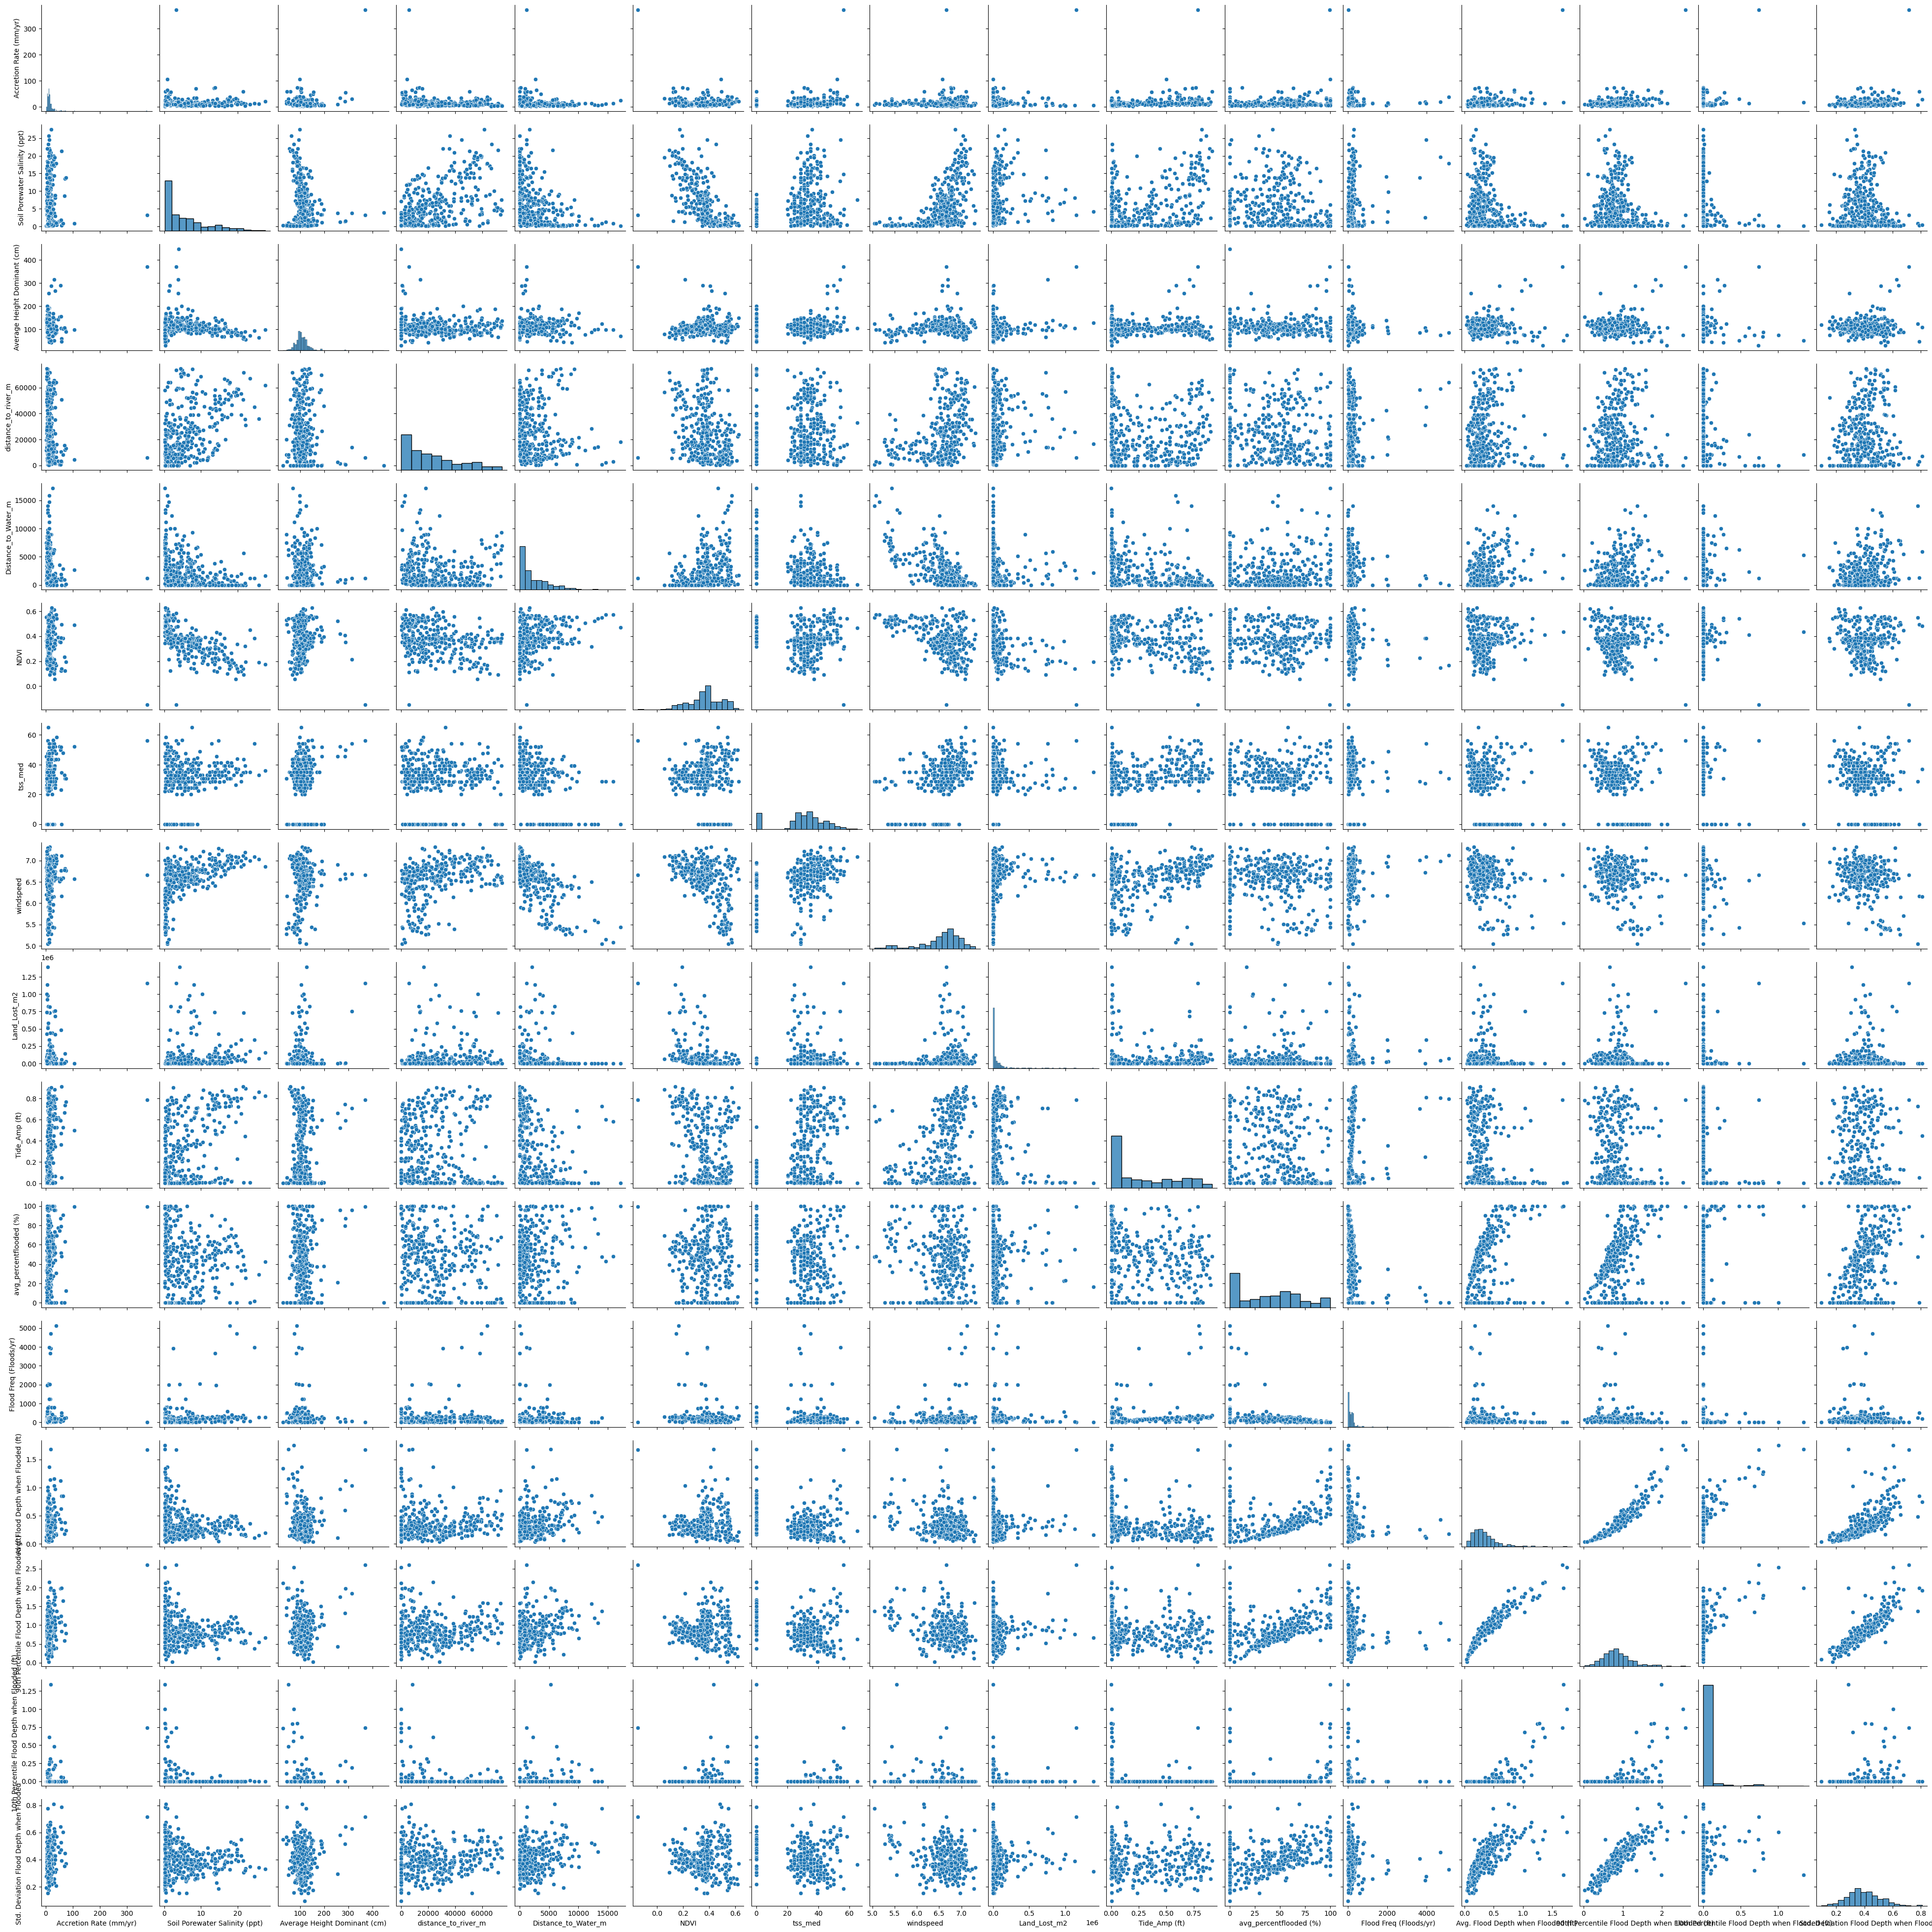

In [16]:
sns.pairplot(data=df)

The only variables that standout as clearly with logarithmic distributions are the distance from water variable and the distance from rivers variable. While, other variables such as 10th Percentile Flood Depth when Flooded (ft), avg_percentflooded (%), and Tide_Amp (ft) have an excessive amount of zero values, conducting a logarithm transform will not correct these distributions in any meaningful way.

A logarithmic transformation is simply taking the natural logarithm, or any logarithm, of the values of a variable. Since the logarithm of zero is undefined, we will use a list comprehension to apply the log transform.

In [17]:
df['log_distance_to_water_m'] = [np.log(val) if val > 0 else 0 for val in df['Distance_to_Water_m']]
df['log_distance_to_river_m'] = [np.log(val) if val > 0 else 0 for val in df['distance_to_river_m']]
# Now drop the variables with the logarithmic distribution
df = df.drop(['Distance_to_Water_m', 'distance_to_river_m'], axis=1)

Something else we may want to do is convert our units into SI units rather than imperial units. It is not a requirement, but might provide some more clarity when interpreting.

In [18]:
# scaling to SI units for formality
df['Distance to River (km)'] = df['log_distance_to_river_m']/1000  # convert to km
df['Distance to Water (km)'] = df['log_distance_to_water_m']/1000  # convert to km
df['Land Lost (km2)'] = df['Land_Lost_m2']*0.000001  # convert to km2

df['Tidal Amplitude (cm)'] = df['Tide_Amp (ft)'] * 30.48
df['90th Percentile Flood Depth (cm)'] = df['90th Percentile Flood Depth when Flooded (ft)'] * 30.48
df['10th Percentile Flood Depth (cm)'] = df['10th Percentile Flood Depth when Flooded (ft)'] * 30.48
df['Avg. Flood Depth (cm)'] = df['Avg. Flood Depth when Flooded (ft)'] * 30.48
df['Std. Deviation Flood Depth (cm)'] = df['Std. Deviation Flood Depth when Flooded '] * 30.48  # notice typo in name

# Drop remade variables
df = df.drop(['log_distance_to_river_m','log_distance_to_water_m','Land_Lost_m2',
              'Tide_Amp (ft)', '90th Percentile Flood Depth when Flooded (ft)', 
              '10th Percentile Flood Depth when Flooded (ft)', 'Avg. Flood Depth when Flooded (ft)',
              'Std. Deviation Flood Depth when Flooded '], axis=1)
# rename variables to nicer names
df = df.rename(columns={'tss_med': 'TSS (mg/l)'})
print(df.columns.values)

['Unnamed: 0' 'Accretion Rate (mm/yr)' 'Soil Porewater Salinity (ppt)'
 'Average Height Dominant (cm)' 'Community' 'NDVI' 'TSS (mg/l)'
 'windspeed' 'avg_percentflooded (%)' 'Flood Freq (Floods/yr)'
 'Distance to River (km)' 'Distance to Water (km)' 'Land Lost (km2)'
 'Tidal Amplitude (cm)' '90th Percentile Flood Depth (cm)'
 '10th Percentile Flood Depth (cm)' 'Avg. Flood Depth (cm)'
 'Std. Deviation Flood Depth (cm)']


In [19]:
# get rid of swamp sites because these sites are underwater basically...
print("Number of Rows with Swamp Stations: ", len(df))
df.drop(df.index[df['Community'] == 'Swamp'], inplace=True)
print("Number of Rows with no Swamp Stations: ", len(df))
print("Check unique columns in community to make sure swamp stations are dropped: ", df['Community'].unique())

Number of Rows with Swamp Stations:  401
Number of Rows with no Swamp Stations:  342
Check unique columns in community to make sure swamp stations are dropped:  ['Brackish' 'Saline' 'Intermediate' 'Freshwater']


Great! Now the last thing we need to do is remove outliers. Outlier removal is an art in itself and there are many different techniques to choose from. For our use case, we want to remove CRMS stations with abnormally high accretion rates. This is because as accretion rates increase, we suppose that more stochastic processes begin to dominant the modes of sediment deposition. Therefore, we remove CRMS stations with accretion rates that are higher than 1.5 times the interquartile range of the distribution of accretion rates.

In [20]:
# outlier removal: by the accretion rate value --> interquartile range
def max_interquartile_outlierrm(df, target):
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1

    filtered_df = df[~(df[target] > (Q3 + 1.5 * IQR))]
    return filtered_df

# check the new number of CRMS stations
df = max_interquartile_outlierrm(df, 'Accretion Rate (mm/yr)')
print("The number of CRMS stations post outlier removal: ", len(df))

The number of CRMS stations post outlier removal:  319


In [21]:
# Now lets drop any NaNs that persist in our dataset
df = df.dropna()
print("Final number of CRMS stations: ", len(df))

Final number of CRMS stations:  266


<a id='_DataDescriptions'></a>
## Brief Data Descriptions

Getting to know our data is crucial. This way we know what processes we are incorporating into our model, which we are excluding, and how many samples we have to capture the full relationship of vertical accretion. 

In [23]:
# lets know how many variables and how many samples we have to work with
print("Number of samples in dataset: ", len(df))
print("Number of features in the dataset: ", len(df.columns))

Number of samples in dataset:  266
Number of features in the dataset:  18


In [25]:
outcome = 'Accretion Rate (mm/yr)'
feature_ls = list(df.columns.values[1:-1]) # make a list including all the variables; 
                                           # excluding the categorical Site and Maarsh community variables
print(feature_ls)

['Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)', 'Average Height Dominant (cm)', 'Community', 'NDVI', 'TSS (mg/l)', 'windspeed', 'avg_percentflooded (%)', 'Flood Freq (Floods/yr)', 'Distance to River (km)', 'Distance to Water (km)', 'Land Lost (km2)', 'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)', '10th Percentile Flood Depth (cm)', 'Avg. Flood Depth (cm)']


## Variable Descriptions

The remaining variables that will be used in the analysis are: 
* **Accretion Rate (mm/yr)**: The amount of sediment deposited above a datum. Recorded with a 6 to 18 month sampling interval.
* **Soil Porewater Salinity (ppt)**: Measured from a syringe inserted into the soil. Recorded variably to annually.
* **Average Height Dominant (cm)**: Survey measurement of the average height of the dominant vegetation species. Sampled annually. 
* **NDVI**: The Normalized Difference Vegetation Index which is an estimate of aboveground biomass from Landsat 7. Samples consisted of an 8 day averages only collected during the months of peak biomass, July-August.
* **TSS (mg/l)**: Estimate of Total Suspended Sediment (TSS) from MODIS. With a 2-day sampling (recurrance) interval.
* **Windspeed**: Reanalysis data from the Global Wind Atlas available from Google Earth Engine (GEE) (The Global Wind Atlas 3 2022).
* **Tidal Amplitude (cm)**: The average daily difference between the highest recorded and lowest hourly water-level as recorded from an underwater sonde.
* **Average Time Flooded (%)**: The percentage of time in which the water-level exceeds the elevation of the marsh. Calculated from hourly water-level measurements from an underwater sonde.
* **Flood Frequency (Floods/yr)**: The number of times that the water-level exceeds the elevation of the marsh. Calculated from hourly water-level measurements from an underwater sonde.
* **Average Flood Depth (cm)**: The average waterlevel when the water-level is higher than the marsh elevation. Calculated from hourly water-level measurements from an underwater sonde. 
* **90th Percentile Flood Depth (cm)**: The 90th percentile of the time series distribution of average flood depth. Calculated from hourly water-level measurements from an underwater sonde.
* **10th Percentile Flood Depth (cm)**: The 10th percentile of the time series distribution of average flood depth. Calculated from hourly water-level measurements from an underwater sonde.
* **Std. Deviation Flood Depth (cm)**: The standard deviation of the time series distribution of average flood depth. Calculated from hourly water-level measurements from an underwater sonde. 
* **Log Distance to Water (km)**: The log of the distance to the nearest water pixel (90% recurrence). As calcculated by the JRC Global Surface Water Dataset (Pekkel et al 2016).
* **Log Distance to River (km)**: The log of the distance to the nearest Global River Width from Landsat (GRWL) dataset river vectors taken from GEE (Allen and Pavelsky 2018). 
* **Community**: Marsh Community (Freshwater, Intermediate, Brackish, Saline, Swamp) determined from surveys of                        vegetation and salinity gradients.

Note that all of these variables spanned either the lifespan of a CRMS site which largely encapsulates 2007 to 2022 (Wagner and Haywood III 2022). 

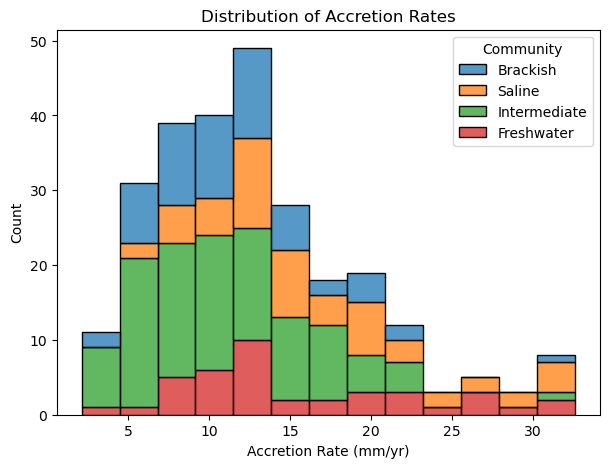

In [26]:
# Let's visualize what we want to predict, 'Accretion Rate (mm/yr)'
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(1, 1, 1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Accretion Rate (mm/yr)", kde=False,
             hue="Community",
             element="bars", legend=True)
ax.set_title("Distribution of Accretion Rates")
ax.set_xlabel("Accretion Rate (mm/yr)")
ax.set_ylabel("Count")
plt.show()

In [27]:
# Let's define our target and design matrix for our ML job
target = df[outcome]
phi = df.drop(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Community'], axis=1)

In [28]:
# Let's get a picture of the target variable, vertical accretion
target.describe()

count    266.000000
mean      13.093916
std        6.449721
min        2.128280
25%        8.226964
50%       12.174938
75%       16.227400
max       32.589286
Name: Accretion Rate (mm/yr), dtype: float64

In [29]:
# Some decriptive statistics to get a picture of the distributions
phi.describe()

,Soil Porewater Salinity (ppt),Average Height Dominant (cm),NDVI,TSS (mg/l),windspeed,avg_percentflooded (%),Flood Freq (Floods/yr),Distance to River (km),Distance to Water (km),Land Lost (km2),Tidal Amplitude (cm),90th Percentile Flood Depth (cm),10th Percentile Flood Depth (cm),Avg. Flood Depth (cm),Std. Deviation Flood Depth (cm)
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,7.186861,112.439643,0.353358,31.821080,6.683651,39.207975,261.107686,0.009934,0.006082,0.090947,9.283287,24.836617,0.314712,9.731371,11.897189
std,6.039870,28.938786,0.110811,13.033298,0.272169,28.512498,549.612559,0.001005,0.002949,0.198047,9.204314,9.858570,1.560128,5.785805,3.026577
min,0.100000,54.860000,0.057249,0.000000,5.864558,0.000000,0.000000,0.005079,0.000000,0.000000,0.060442,0.914400,0.000000,1.173515,4.595155
25%,2.425000,97.000000,0.292554,28.556742,6.525110,15.867526,51.426390,0.009427,0.005693,0.001554,0.312294,18.267426,0.000000,5.835615,10.014167
50%,5.600000,108.300000,0.364691,32.970487,6.703245,39.127680,161.037234,0.010165,0.007177,0.020488,6.584424,24.292560,0.000000,8.483845,11.656643
75%,10.300000,122.100000,0.399708,39.331860,6.872427,59.170743,250.736063,0.010722,0.008095,0.080221,18.043368,29.794200,0.000000,12.263635,13.760751
max,27.500000,315.800000,0.627081,65.011248,7.315856,99.999999,4693.096330,0.011222,0.009412,1.394380,27.500165,65.257680,18.592800,41.731574,24.649485
